In [1]:
import os
import sys
import scipy
from numba import njit, prange
import numpy as np
import scipy.stats as stats
import bayesflow as bf
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import pickle
import tensorflow as tf
import pandas as pd
import priors_and_simulators as ps

# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(2023)

2024-08-12 10:49:11.128341: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 10:49:11.149842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 10:49:11.463869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mischa/miniconda3/envs/bf/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook imp

In [8]:
#Settings
# Path to data
PATH = '/home/mischa/Documents/bayesflow/prj_real_life_ddm/data/ensemble_check/'

# Path to outcomes
PATH_OUTCOME = '/home/mischa/Documents/bayesflow/prj_real_life_ddm/data/outcomes/'

# where to save files
PATH_TO_SAVE = '/home/mischa/Documents/bayesflow/prj_real_life_ddm/data/estimates/ensemble_check_gsr/'

In [4]:
# Get network settings

PARAM_NAMES = [
    r"$\gamma$",
    r"$v_{word}$",
    r"$v_{picture}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",

    r"$\tau_{correct}$",
    r"$\tau_{error}$",
    r"$s_{v}$",
    r"$s_{ndt}$"
]


prior = bf.simulation.Prior(prior_fun=ps.gsr_ddm_prior_fun, param_names=PARAM_NAMES)

prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_means = np.round(prior_means, decimals=1)
prior_stds = np.round(prior_stds, decimals=1)

simulator = bf.simulation.Simulator(simulator_fun=ps.gsr_ddm_simulator_fun)

model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, name="gsr_ddm")

def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    out_dict = {}
    out_dict["summary_conditions"] = forward_dict["sim_data"]
    params = forward_dict["prior_draws"].astype(np.float32)
    # Standardize parameters
    out_dict["parameters"] = (params - prior_means) / prior_stds
    
    return out_dict

summary_net = bf.networks.SetTransformer(input_dim=4, summary_dim=30, name="ddm_summary")

inference_net = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="ddm_inference")

amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name="ddm_amortizer",
                                            summary_loss_fun='MMD')

INFO:root:Performing 2 pilot runs with the gsr_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 120, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
2024-08-12 10:49:48.457278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 10:49:48.472543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at leas

# Load neural networks from checkpoints and get estimates

In [27]:
#This is where the magic happens

# 1. Store all data-set chunk names in a list
datasets = sorted(os.listdir(PATH))

# 2. For each network

for network in ("gsr_ddm_120_net1", "gsr_ddm_120_net2"):
    
    trainer = bf.trainers.Trainer(
        generative_model=model, amortizer=amortizer, configurator= configurator, checkpoint_path=network)

    # 3. For each chunk
        
    for dataset_name in datasets:
            
            # 3.1 Load chunk
        
            loaded_pickle = pickle.load(open(PATH +str(dataset_name), "rb" ))
        
            X_test = loaded_pickle['data_array']
            y_test = loaded_pickle['outcome_array']
            rt_summaries = loaded_pickle['rt_summaries']

            # 3.2 Estimate parameters, de-standardize

            samples_dm = np.concatenate([amortizer.sample(input_dict = {"summary_conditions": x}, n_samples=3000,
                                                  to_numpy=True) for x in np.array_split(X_test, 50)], axis=0)

            samples_dm = samples_dm * prior_stds + prior_means

            # 3.3 Compute summaries: means, medians, stds, Q0.025, Q0.0975
            
            estimates = ps.compute_summaries(samples_dm)
        
            # 3.4 Store everything together (serialized, pickle.dump) as a dict with keys 
        
            dict_to_store = {'est_array': estimates, 'outcome_array': y_test}
        
            pickle.dump(dict_to_store,
                    open(PATH_TO_SAVE + str(network) +"/" + 
                         str(dataset_name),"wb"))
            
            print(str(dataset_name)+ str(network))

# 3. Celebrate

INFO:root:Loaded loss history from gsr_ddm_120_net1/history_200.pkl.
INFO:root:Networks loaded from gsr_ddm_120_net1/ckpt-200
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


prepared_False2021iat20.pgsr_ddm_120_net1
prepared_True2021iat20.pgsr_ddm_120_net1


INFO:root:Loaded loss history from gsr_ddm_120_net2/history_200.pkl.
INFO:root:Networks loaded from gsr_ddm_120_net2/ckpt-200
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


prepared_False2021iat20.pgsr_ddm_120_net2
prepared_True2021iat20.pgsr_ddm_120_net2


In [28]:
# GET ESTIMATES FROM NETWORK 1
ESTIMATES_PATH = PATH_TO_SAVE + "/gsr_ddm_120_net1/"

# Load data chunks

Frame = pd.DataFrame()
datasets = os.listdir(ESTIMATES_PATH)
for dataset in datasets:
        pickles = pickle.load(open(ESTIMATES_PATH +str(dataset), "rb" ))

        df_oneset = np.concatenate((pickles['est_array'], pickles['outcome_array']),
                                   axis=1)  
        Frame = Frame.append(pd.DataFrame(data = df_oneset), ignore_index=True)
        print(str(dataset)+" done")
df_net1 = Frame.rename(columns={0: "similarity_net1", 1: "v_word_net1", 2: "v_picture_net1",
                                3: "a_congruent_net1", 4: "a_incongruent_net1", 5: "tplus_net1", 6: "tminus_net1",
                           7: "sv_net1", 8: "st0_net1", 45:"id"}) 
df_net1

prepared_False2021iat20.p done
prepared_True2021iat20.p done


/tmp/ipykernel_1749878/2194123917.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Frame = Frame.append(pd.DataFrame(data = df_oneset), ignore_index=True)


,similarity_net1,v_word_net1,v_picture_net1,a_congruent_net1,a_incongruent_net1,tplus_net1,tminus_net1,sv_net1,st0_net1,9,...,37,38,39,40,41,42,43,44,id,46
0,-0.087396,2.098122,3.037661,2.973694,2.347955,0.388758,0.636080,1.444227,0.081277,-0.088287,...,2.936852,4.175988,3.773829,3.030378,0.441064,0.882544,2.129329,0.181754,2.661896e+09,51.0
1,0.408240,1.733379,2.354033,1.900389,2.653469,0.589432,0.996584,0.534540,0.188386,0.412241,...,2.388989,3.206428,2.660709,3.309053,0.678694,1.267655,1.195945,0.319931,2.661896e+09,62.0
2,-0.136733,3.419703,3.902677,4.406195,2.436637,0.438220,0.906495,1.884943,0.048231,-0.136759,...,4.522227,5.096480,5.469122,3.120008,0.477858,1.247734,2.502486,0.136941,2.661896e+09,63.0
3,0.263432,2.145152,3.391350,1.796483,2.061622,0.409589,0.748845,1.894748,0.076778,0.262173,...,3.190980,4.769554,2.315404,2.618263,0.447244,0.846939,2.867500,0.170514,2.661896e+09,19.0
4,0.069839,2.724241,2.019381,1.168670,2.080912,0.361726,0.598393,1.250447,0.143310,0.071064,...,3.834829,3.058175,1.475466,2.638415,0.400775,0.659973,2.249155,0.193028,2.661896e+09,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11888,-0.131877,3.645286,3.111971,2.109850,2.538439,0.509640,0.831003,1.795005,0.156096,-0.131108,...,4.889140,4.302467,2.616578,3.281687,0.561087,1.001132,2.561701,0.243463,2.662199e+09,47.0
11889,-0.103525,2.623358,2.529843,2.219042,2.495589,0.356336,1.797766,0.794867,0.095262,-0.102922,...,3.551359,3.433459,2.949592,3.436252,0.419330,2.481644,1.459381,0.190041,2.662199e+09,34.0
11890,0.100009,2.229124,3.023258,3.472196,4.160792,0.448517,1.912617,1.312647,0.108044,0.099515,...,2.989051,4.061657,4.631823,5.365250,0.537887,2.959863,1.837592,0.237331,2.662199e+09,26.0
11891,0.223249,2.475297,3.236251,2.704843,2.147850,0.412006,2.487988,1.184787,0.092309,0.225490,...,3.495251,4.409012,3.765797,2.757281,0.471498,2.766638,1.880657,0.209902,2.662199e+09,27.0


In [29]:
# GET ESTIMATES FROM NETWORK 2

ESTIMATES_PATH = PATH_TO_SAVE + "/gsr_ddm_120_net2/"

# Load data chunks

Frame = pd.DataFrame()
datasets = os.listdir(ESTIMATES_PATH)
for dataset in datasets:
        pickles = pickle.load(open(ESTIMATES_PATH +str(dataset), "rb" ))

        df_oneset = np.concatenate((pickles['est_array'], pickles['outcome_array']),
                                   axis=1)  
        Frame = Frame.append(pd.DataFrame(data = df_oneset), ignore_index=True)
        print(str(dataset)+" done")
df_net2 = Frame.rename(columns={0: "similarity_net2", 1: "v_word_net2", 2: "v_picture_net2",
                                3: "a_congruent_net2", 4: "a_incongruent_net2", 5: "tplus_net2", 6: "tminus_net2",
                           7: "sv_net2", 8: "st0_net2", 45:"id"}) 
df_net2

prepared_False2021iat20.p done
prepared_True2021iat20.p done


/tmp/ipykernel_1749878/2386371956.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Frame = Frame.append(pd.DataFrame(data = df_oneset), ignore_index=True)


,similarity_net2,v_word_net2,v_picture_net2,a_congruent_net2,a_incongruent_net2,tplus_net2,tminus_net2,sv_net2,st0_net2,9,...,37,38,39,40,41,42,43,44,id,46
0,-0.091741,2.085601,3.032336,2.965250,2.351167,0.388148,0.634163,1.443886,0.079889,-0.091753,...,2.904900,4.172876,3.739136,3.042068,0.442138,0.887457,2.110271,0.178720,2.661896e+09,51.0
1,0.407492,1.726673,2.348917,1.902640,2.647366,0.588048,0.998640,0.526397,0.187443,0.411177,...,2.387235,3.201981,2.685169,3.294390,0.675533,1.261491,1.157204,0.320120,2.661896e+09,62.0
2,-0.136150,3.421649,3.902110,4.402892,2.437771,0.438106,0.894866,1.875740,0.046716,-0.138128,...,4.451754,5.086138,5.494528,3.145290,0.475780,1.236985,2.512161,0.135597,2.661896e+09,63.0
3,0.264045,2.128356,3.385233,1.794489,2.060692,0.409714,0.747675,1.895702,0.077244,0.262323,...,3.183223,4.709382,2.345707,2.604621,0.446743,0.844770,2.856161,0.169072,2.661896e+09,19.0
4,0.066082,2.742435,2.031059,1.173700,2.083149,0.361680,0.596672,1.266669,0.143515,0.067101,...,3.941032,3.050380,1.506815,2.637262,0.401056,0.658784,2.311240,0.193217,2.661896e+09,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11888,-0.133344,3.618390,3.094676,2.107820,2.546327,0.508507,0.830266,1.787499,0.155626,-0.136305,...,4.809194,4.315548,2.631400,3.299184,0.559194,0.997357,2.535542,0.243738,2.662199e+09,47.0
11889,-0.101780,2.634843,2.538011,2.211626,2.486663,0.358098,1.801025,0.808465,0.096766,-0.102445,...,3.631126,3.430934,2.935875,3.421415,0.418288,2.482496,1.470931,0.190142,2.662199e+09,34.0
11890,0.097348,2.214002,3.033078,3.469191,4.171099,0.447524,1.922909,1.310605,0.105057,0.097117,...,2.984909,4.145105,4.583595,5.407796,0.536173,2.961568,1.839767,0.236092,2.662199e+09,26.0
11891,0.222853,2.464538,3.224873,2.704617,2.144031,0.411955,2.481417,1.177424,0.092928,0.224317,...,3.420979,4.399568,3.719800,2.749677,0.470743,2.766696,1.919570,0.206112,2.662199e+09,27.0


In [30]:
# Merge ensemble data
df = df_net1.merge(df_net2, left_on='id', right_on='id')

In [31]:
# Example across-ensemble correlation
np.corrcoef(x=df["similarity_net1"], y=df["similarity_net2"])

array([[1.        , 0.99989227],
       [0.99989227, 1.        ]])

<Axes: xlabel='st0_net1', ylabel='st0_net2'>

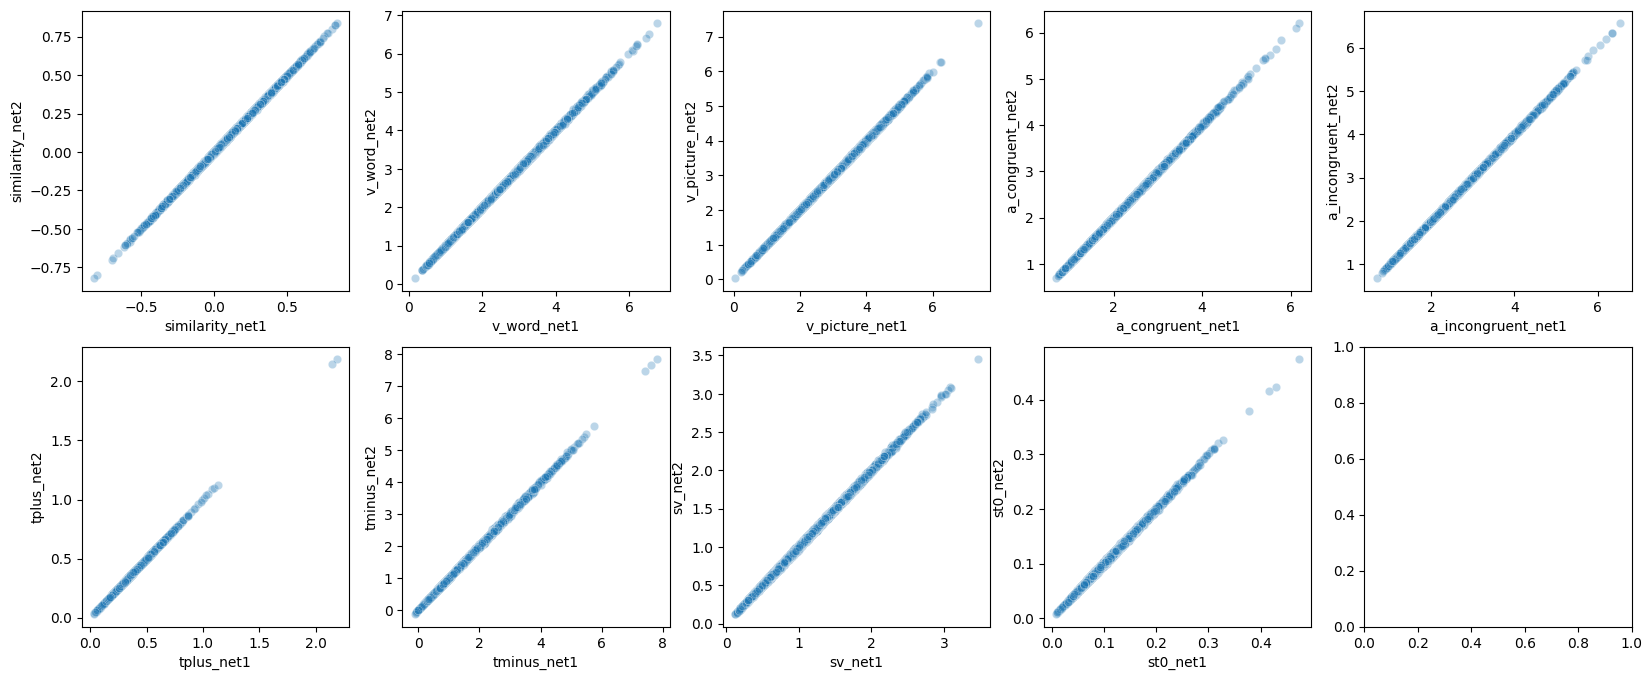

In [32]:
# Create scatterplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

sns.scatterplot(ax=axes[0, 0], x=df["similarity_net1"], y=df["similarity_net2"], alpha=.3)
sns.scatterplot(ax=axes[0, 1], x=df["v_word_net1"], y=df["v_word_net2"], alpha=.3)
sns.scatterplot(ax=axes[0, 2], x=df["v_picture_net1"], y=df["v_picture_net2"], alpha=.3)

sns.scatterplot(ax=axes[0, 3], x=df["a_congruent_net1"], y=df["a_congruent_net2"], alpha=.3)
sns.scatterplot(ax=axes[0, 4], x=df["a_incongruent_net1"], y=df["a_incongruent_net2"], alpha=.3)

sns.scatterplot(ax=axes[1, 0], x=df["tplus_net1"], y=df["tplus_net2"], alpha=.3)
sns.scatterplot(ax=axes[1, 1], x=df["tminus_net1"], y=df["tminus_net2"], alpha=.3)

sns.scatterplot(ax=axes[1, 2], x=df["sv_net1"], y=df["sv_net2"], alpha=.3)
sns.scatterplot(ax=axes[1, 3], x=df["st0_net1"], y=df["st0_net2"], alpha=.3)